## Import needed Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

## Read Images

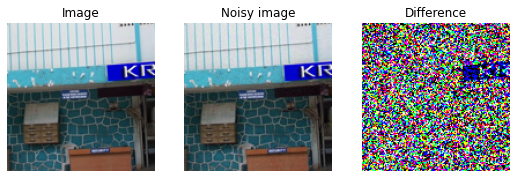

In [2]:
krishna = imread('krishna.png')
krishna_noisy = imread('krishna_0_001.png')
    
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.imshow(krishna, 'gray')
ax1.title.set_text('Image')
ax2.imshow(krishna_noisy, 'gray')
ax2.title.set_text('Noisy image')
ax3.imshow(krishna_noisy-krishna, 'gray')
ax3.title.set_text('Difference')

plt.axis('off')
plt.show()

### Zero Pad Image

In [3]:
def zero_pad_image(image, w, w_sim):
    x, y, _ = np.shape(image)
    pad_size = w+w_sim
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size, 3))
    for i in range(3):
        padded_image[pad_size:-pad_size,
                     pad_size:-pad_size, i] = image[:, :, i]
    return padded_image

# PSNR
Calculate the PSNR between a noisy image and its underlying latent image. PSNR in decibels (dB) is defined as 

$$
20log_{10}\left(\frac{MAX_{f}}{\sqrt{MSE}}\right)
$$

$MAX_{f}$ is the maximum intensity value in the underlying image and $MSE$ is the mean-squared error between the noisy image and the underlying image. If the $MSE$ is zero, return a really high but finite value to prevent division by zero errors.

In [4]:
def PSNR(latent_image, noisy_image):
    mse = np.mean((noisy_image-latent_image)**2)
    if mse > 0:
        return 20*np.log10(np.max(latent_image)/np.sqrt(mse))
    else:
        return np.float128('2e315')

# Non-Local Means Filtering

The non-local means filter takes a patch $N_p$ around pixel 'p' and for 'q' in the image and image patch $N_q$ around the same, applies a Gaussian filter that takes to account the value of the intensity of 'q' based on its neighbourhood. Thus the intensity at 'p' can be given as $ g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(N_{p}-N_{q})f(q)$. Here $G_p$ is the window in p's neighbourhood of size $(2d+1)(2d+1)$

### $G_{\sigma}(x)$: Gaussian Sigma function

In [5]:
def gaussian_sigma(p, q, sigma):
    if sigma > 0:
        return np.exp(np.sum((-1*(p-q)**2)/(2*sigma**2)))
    else:
        if np.sum(np.abs(p-q)) == 0:
            return 1
        else:
            return 0

### NLM for patch $N_p$

In [6]:
def NLM_patch(impatch, surroundings, d, W_sim, sigma, return_kernel=False):
    # create a weight matrix of the required size. It is to be noted
    # here that the d input is the sum W + W_sim and hence, W_sim is 
    # subtracted whenever required 
    weights = np.zeros((2*d+1 - 2*W_sim, 2*d+1 - 2*W_sim))
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            # get the patch around another pixel of the size (2*W_sim+1, 2*W_sim+1)
            q = surroundings[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
            # get the weights
            weights[i-W_sim, j-W_sim] = gaussian_sigma(impatch, q, sigma)
            # increment the filtered value
            filtered_val += weights[i-W_sim, j-W_sim]*surroundings[i, j]
    # if the kernel is required for visualization, return it. Else return
    # only the filtered value. Normalize both the kernel and the weights so
    # that the weights sum up to 1 and we do not brighten or dim the image
    if return_kernel:
        return filtered_val/np.sum(weights), weights/np.sum(weights)
    else:
        return filtered_val/np.sum(weights)

### NLM on the noisy image

In [7]:
def NLM(image, W, W_sim, sigma):
    # get the image shape
    x, y, _ = np.shape(image)
    # zero pad the image
    padded_image = zero_pad_image(image, W, W_sim)
    d = W + W_sim
    filtered_image = np.zeros((x, y, 3))
    # for each channel
    for channel in range(3):
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                # get the patch around a pixel of shape (2*W_sim+1, 2*W_sim+1)
                impatch = padded_image_channel[i -
                                               W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
                # get its surroundings of shape (2*W+1, 2*W+1)
                surroundings = padded_image_channel[i-d:i+d+1, j-d:j+d+1]
                # get the filtered value
                filtered_image[i-d, j-d, channel] = NLM_patch(
                    impatch, surroundings, d, W_sim, sigma)
    return filtered_image

### Observing NLM

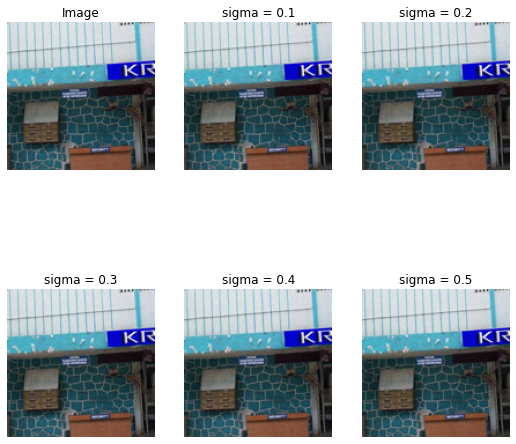

In [8]:
sigma = {0.1,0.2,0.3,0.4,0.5}
W = 3
W_sim = 3
d = W+W_sim
x,y,z = np.shape(krishna_noisy)
krishna_NLM_filtered = {}
PSNR_NLM_W3 = {}
for i in sigma:
    krishna_NLM_filtered[i] = NLM(krishna_noisy, W, W_sim, i)
    PSNR_NLM_W3[i] = PSNR(krishna,krishna_NLM_filtered[i])
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')

ax1.imshow(krishna_noisy*1/np.max(krishna_noisy), 'gray')
ax1.title.set_text('Image')
ax2.imshow(krishna_NLM_filtered[0.1]*1/np.max(krishna_NLM_filtered[0.1]), 'gray')
ax2.title.set_text('sigma = 0.1')
ax3.imshow(krishna_NLM_filtered[0.2]*1/np.max(krishna_NLM_filtered[0.2]), 'gray')
ax3.title.set_text('sigma = 0.2')
ax4.imshow(krishna_NLM_filtered[0.3]*1/np.max(krishna_NLM_filtered[0.3]), 'gray')
ax4.title.set_text('sigma = 0.3')
ax5.imshow(krishna_NLM_filtered[0.4]*1/np.max(krishna_NLM_filtered[0.4]), 'gray')
ax5.title.set_text('sigma = 0.4')
ax6.imshow(krishna_NLM_filtered[0.5]*1/np.max(krishna_NLM_filtered[0.5]), 'gray')
ax6.title.set_text('sigma = 0.5')

plt.axis('off')
plt.show()

In [9]:
display(PSNR_NLM_W3)

{0.1: 37.722245780760936,
 0.4: 37.722245780760936,
 0.2: 37.722245780760936,
 0.3: 37.722245780760936,
 0.5: 37.722245780760936}